In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
from dgl.data.dgl_dataset import DGLBuiltinDataset
from scipy import io
import numpy as np
import os
import zipfile
from zipfile import ZipFile
import shutil

from dgl.data import DGLDataset
from dgl.data.utils import download, check_sha1
import dgl
import pandas as pd
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 MB 10.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
class ICALBenchmarkGraphDataset(dgl.data.DGLBuiltinDataset):
    _url ="https://github.com/Hemalatanayak/ical_graph_data/raw/master/ical_mu%2B_up/"
    # https://github.com/Hemalatanayak/ical_graph_data/raw/master/ical_mu%2B_up/ical_mup_up_1.zip
    #https://github.com/Hemalatanayak/ical_graph_data/raw/master/ical_mu%2B_up/ical_mup_up_2.zip
    nParts=1 # no. of zip file parts
    minNodes=10
    def __init__(self, raw_dir='/content/dgl_graphs', force_reload=False, verbose=False, n_parts=1, min_nodes=10):
        self.nParts = n_parts
        self.minNodes=min_nodes
        super(ICALBenchmarkGraphDataset, self).__init__(name='ical_mup_up',
                                          url=self._url,
                                          raw_dir=raw_dir,
                                          force_reload=force_reload,
                                          verbose=verbose)

    def combine_folders(self, src_folders, dst_folder):
        print("merging unzipped folders...")
        print(src_folders)
        os.makedirs(dst_folder, exist_ok=True)
        for folder in src_folders:
            for file_name in os.listdir(folder):
                src_file_path = os.path.join(folder, file_name)
                if os.path.isfile(src_file_path):
                    dst_file_path = os.path.join(dst_folder, file_name)
                    shutil.copy(src_file_path, dst_file_path)


    def download(self):
        # print("Downloading graphs...")
        # download(self.url + self.name+"_1"+".zip")
        # download(self.url + self.name+"_2"+".zip")
        # download(self.url + self.name+"_3"+".zip")
        # print("Downloading graphs...")
        src_folders=[]
        for i in range(1, self.nParts + 1):
            # print(self.nParts)
            # print("Downloading {} of {}".format(i,self.nParts))
            file_name = f"{self.name}_{i}"
            download(self.url + file_name+".zip")
            zip_file_path = os.path.join("/content/", file_name+".zip")
            # print(zip_file_path)
            with ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall()
            src_folders.append(os.path.join("/content/", file_name))
            dst_folder= self.raw_dir
        print(src_folders)
        print(dst_folder)
        self.combine_folders(src_folders, dst_folder)
        # # pass


    def process(self):
        # process data to a list of graphs and a list of labels
        # print("processing...")
        self.graphs, self.label, self.graphID = self._load_graph(self.raw_dir)

    def get_graph_label(self, graph_name):
        graphID = os.path.splitext(os.path.basename(graph_name))[0].split("_")[-1]
        label=int(int(graphID)/10000)
        # label = int(int(graphID)/10000)
        # if true_label <= 5:
        #     label=0
        # else:
        #     label=1
        return label-1

    def get_graphID(self, graph_name):
        graphIDs = os.path.splitext(os.path.basename(graph_name))[0].split("_")[-1]
        graphID =int(graphIDs)
        return graphID

    def _load_graph(self,foldername):
        graphs = []
        labels = []
        graphIDs= []
        for graph_name in os.listdir(foldername):
            if graph_name.endswith('.dgl'):
                file_path = os.path.join(foldername, graph_name)
                graph, _ = dgl.load_graphs(file_path)
                if graph[0].num_nodes() >= self.minNodes: # only load graphs with at least minNodes nodes
                    # print(graph[0].num_nodes())
                    graphs.append(graph[0])
                    label = self.get_graph_label(graph_name)
                    labels.append(label)
                    graphID=self.get_graphID(graph_name)
                    graphIDs.append(graphID)
                    # print(f"Loaded {graph_name}, label={label}")
        # print("Number of graphs: {}".format(len(graphs)))
        return graphs, labels, graphIDs

                # for g in graph:
                #     print(f"Loaded {graph_name}, label={get_graph_label(graph_name)}")
                #     print(g)
                #     print(f"Node features: {g.ndata}")
                #     print(f"Edge features: {g.edata}")
                # print(graph,label)
                # print(f"Loaded {graph_name}, label={label}")



    def __getitem__(self, idx):
        """ Get graph and label by index

        Parameters
        ----------
        idx : int
            Item index

        Returns
        -------
        (dgl.DGLGraph, Tensor)
        """
        return self.graphs[idx], self.label[idx],self.graphID[idx]

    def __len__(self):
        """Number of graphs in the dataset"""
        return len(self.graphs)

In [ ]:
import torch
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
dataset=ICALBenchmarkGraphDataset(n_parts=5)

['/content/ical_mup_up_1', '/content/ical_mup_up_2', '/content/ical_mup_up_3', '/content/ical_mup_up_4', '/content/ical_mup_up_5']
/content/dgl_graphs
merging unzipped folders...
['/content/ical_mup_up_1', '/content/ical_mup_up_2', '/content/ical_mup_up_3', '/content/ical_mup_up_4', '/content/ical_mup_up_5']


In [ ]:
def collate(batch):
    graphs, labels, graphID = map(list, zip(*batch))
    g=dgl.batch(graphs)
    batched_labels = torch.tensor(labels)
    batched_graphIDs=torch.tensor(graphID)
    return g, batched_labels,batched_graphIDs

# create dataloaders
from dgl.dataloading import GraphDataLoader
dataloader = GraphDataLoader(dataset, batch_size=200, shuffle=True,collate_fn=collate)
# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = GraphDataLoader(train_dataset, batch_size=200, shuffle=False, collate_fn=collate)
test_loader = GraphDataLoader(test_dataset, batch_size=200, shuffle=False, collate_fn=collate)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, feats):
        h = self.conv1(g, feats)
        h = F.relu(h)
        # h = F.dropout(h, p=0.5, training=self.training)  # Add dropout
        h = self.conv2(g, h)
        h = F.relu(h)
        # h = F.dropout(h, p=0.5, training=self.training)  # Add dropout
        with g.local_scope():
          g.ndata['pos'] = h
          # Calculate graph representation by average readout.
          hg = dgl.mean_nodes(g, 'pos')
          return self.classify(hg)

In [ ]:
model = Classifier(4, 20, 10)
opt = torch.optim.Adam(model.parameters())
for epoch in range(50):
    model.train()
    for g, batched_labels, batched_graphIDs in train_loader:
        feats = g.ndata['pos'].float()
        logits = model(g, feats)
        loss = F.cross_entropy(logits, batched_labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    graphIDs=[]
    with torch.no_grad():
        for g, batched_labels,batched_graphIDs in test_loader:
            feats = g.ndata['pos'].float()
            logits = model(g, feats)
            predict=logits
            pred = logits.argmax(dim=1)
            y_true.extend(batched_labels.numpy())
            y_pred.extend(pred.numpy())
            graphIDs.extend(batched_graphIDs.numpy())
            correct += (predict.argmax(1) == batched_labels).sum().item()
            total += len(batched_labels)

        accuracy = 100 * correct / total
        print(f'Epoch {epoch}: Test accuracy: {accuracy:.2f}%')

In [ ]:
model=torch.load('/content/ical_model.pt')
# model=torch.load()
for epoch in range(50):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    graphIDs=[]
    with torch.no_grad():
        for g, batched_labels,batched_graphIDs in test_loader:
            feats = g.ndata['pos'].float()
            logits = model(g, feats)
            predict=logits
            pred = logits.argmax(dim=1)
            y_true.extend(batched_labels.numpy())
            y_pred.extend(pred.numpy())
            graphIDs.extend(batched_graphIDs.numpy())
            correct += (predict.argmax(1) == batched_labels).sum().item()
            total += len(batched_labels)

        accuracy = 100 * correct / total
        print(f'Epoch {epoch}: Test accuracy: {accuracy:.2f}%')

        # print(len(y_true))
        # print(len(y_pred))
        # print(g)
        # print(y_true)
        # print(y_pred)


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0: Test accuracy: 87.52%
Epoch 1: Test accuracy: 87.52%
Epoch 2: Test accuracy: 87.52%
Epoch 3: Test accuracy: 87.52%
Epoch 4: Test accuracy: 87.52%
Epoch 5: Test accuracy: 87.52%
Epoch 6: Test accuracy: 87.52%
Epoch 7: Test accuracy: 87.52%
Epoch 8: Test accuracy: 87.52%
Epoch 9: Test accuracy: 87.52%
Epoch 10: Test accuracy: 87.52%
Epoch 11: Test accuracy: 87.52%
Epoch 12: Test accuracy: 87.52%
Epoch 13: Test accuracy: 87.52%
Epoch 14: Test accuracy: 87.52%
Epoch 15: Test accuracy: 87.52%
Epoch 16: Test accuracy: 87.52%
Epoch 17: Test accuracy: 87.52%
Epoch 18: Test accuracy: 87.52%
Epoch 19: Test accuracy: 87.52%
Epoch 20: Test accuracy: 87.52%
Epoch 21: Test accuracy: 87.52%
Epoch 22: Test accuracy: 87.52%
Epoch 23: Test accuracy: 87.52%
Epoch 24: Test accuracy: 87.52%
Epoch 25: Test accuracy: 87.52%
Epoch 26: Test accuracy: 87.52%
Epoch 27: Test accuracy: 87.52%
Epoch 28: Test accuracy: 87.52%
Epoch 29: Test accuracy: 87.52%
Epoch 30: Test accuracy: 87.52%
Epoch 31: Test acc

Confusion Matrix:
 [[1976    0    1    0    0    1    0    0    0    0]
 [   0 1949   14    2    3    0    2    0    0    1]
 [   0    0 1957   42    1    2    1    1    0    1]
 [   0    0    2 1908   94    4    2    0    1    0]
 [   0    0    0   21 1924  147   16    3    0    1]
 [   0    0    0    0  106 1727  198   25    7    1]
 [   0    0    0    0    0  145 1751  407   48   20]
 [   0    0    0    0    0    0   45 1428  369   78]
 [   0    0    0    0    0    0    0  111 1479  454]
 [   0    0    0    0    0    0    0    0  118 1405]]


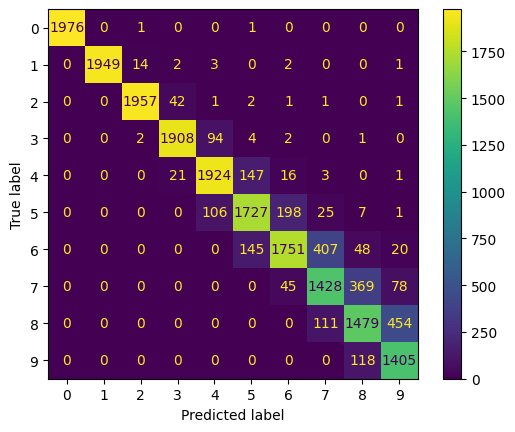

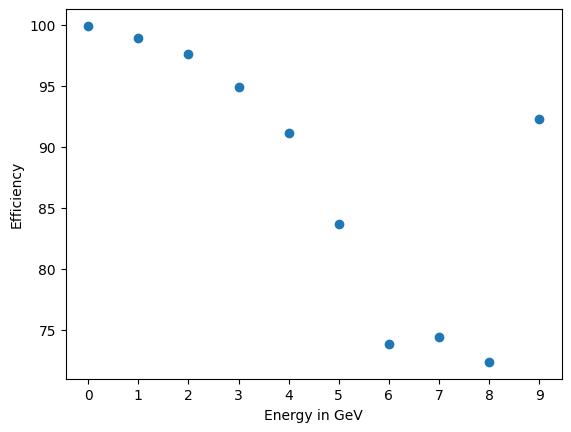

In [ ]:
conf_matrix = confusion_matrix(y_pred, y_true)
print('Confusion Matrix:\n', conf_matrix)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(conf_matrix)  #, logits,y_true, cmap=plt.cm.Blues)
matrix.plot()


plt.show()
# import numpy as np
np.save("confusion_matrix.npy", conf_matrix)
cm = np.load("confusion_matrix.npy")
# print(cm)
recall = (np.diag(cm) / cm.sum(axis=1))*100

# Plot the recall for each class
plt.scatter(range(10), recall)
plt.xticks(range(10))
# plt.ylim([0, 1])
plt.xlabel('Energy in GeV')
plt.ylabel('Efficiency')
plt.show()

In [ ]:
# for i in range (0,20000):
for i in range(min(len(y_true), len(y_pred), len(graphIDs))):
  if y_true[i] != y_pred[i] :
      print(y_true[i])
      print(y_pred[i])
      print(graphIDs[i])
      print(len(y_true))
      print(len(y_pred))
      print(len(graphIDs))

Streaming output truncated to the last 5000 lines.
19999
19999
8
7
93074
19999
19999
19999
9
8
100055
19999
19999
19999
9
8
100286
19999
19999
19999
6
4
70380
19999
19999
19999
7
6
82645
19999
19999
19999
9
8
107038
19999
19999
19999
4
3
58212
19999
19999
19999
6
3
70971
19999
19999
19999
8
7
96448
19999
19999
19999
6
7
75010
19999
19999
19999
7
6
89729
19999
19999
19999
8
7
96267
19999
19999
19999
9
8
103207
19999
19999
19999
8
9
92372
19999
19999
19999
9
8
101563
19999
19999
19999
6
5
71815
19999
19999
19999
7
8
89039
19999
19999
19999
8
6
93404
19999
19999
19999
9
8
101802
19999
19999
19999
7
6
80584
19999
19999
19999
8
7
97738
19999
19999
19999
8
7
91999
19999
19999
19999
5
4
68582
19999
19999
19999
7
6
89816
19999
19999
19999
8
6
97789
19999
19999
19999
9
7
103963
19999
19999
19999
4
3
59643
19999
19999
19999
8
6
94354
19999
19999
19999
9
8
101391
19999
19999
19999
7
6
86818
19999
19999
19999
5
6
63680
19999
19999
19999
6
5
72775
19999
19999
19999
8
7
96253
19999
19999
19999
5
6
6

In [ ]:
import csv
data = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        data.append([y_true[i], y_pred[i], graphIDs[i]])
    np.save('graphIDs.npy', graphIDs)
with open('mismatched_predictions.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['True Label', 'Predicted Label', 'graphID'])
    writer.writerows(data)



In [ ]:
print(len(graphIDs))
print(len(data))

19999
2495


In [ ]:
model=torch.load('/content/ical_model.pt')
# model=torch.load()
for epoch in range(50):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    graphIDs=[]
    with torch.no_grad():
        for g, batched_labels,batched_graphIDs in test_loader:
            feats = g.ndata['pos'].float()
            logits = model(g, feats)
            predict=logits
            pred = logits.argmax(dim=1)
            y_true.extend(batched_labels.numpy())
            y_pred.extend(pred.numpy())
            graphIDs.extend(batched_graphIDs.numpy())
            correct += (predict.argmax(1) == batched_labels).sum().item()
            total += len(batched_labels)

        accuracy = 100 * correct / total
        print(f'Epoch {epoch}: Test accuracy: {accuracy:.2f}%')

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0: Test accuracy: 87.75%
Epoch 1: Test accuracy: 87.75%
Epoch 2: Test accuracy: 87.75%
Epoch 3: Test accuracy: 87.75%
Epoch 4: Test accuracy: 87.75%
Epoch 5: Test accuracy: 87.75%
Epoch 6: Test accuracy: 87.75%
Epoch 7: Test accuracy: 87.75%
Epoch 8: Test accuracy: 87.75%
Epoch 9: Test accuracy: 87.75%
Epoch 10: Test accuracy: 87.75%
Epoch 11: Test accuracy: 87.75%
Epoch 12: Test accuracy: 87.75%
Epoch 13: Test accuracy: 87.75%
Epoch 14: Test accuracy: 87.75%
Epoch 15: Test accuracy: 87.75%
Epoch 16: Test accuracy: 87.75%
Epoch 17: Test accuracy: 87.75%
Epoch 18: Test accuracy: 87.75%
Epoch 19: Test accuracy: 87.75%
Epoch 20: Test accuracy: 87.75%
Epoch 21: Test accuracy: 87.75%
Epoch 22: Test accuracy: 87.75%
Epoch 23: Test accuracy: 87.75%
Epoch 24: Test accuracy: 87.75%
Epoch 25: Test accuracy: 87.75%
Epoch 26: Test accuracy: 87.75%
Epoch 27: Test accuracy: 87.75%
Epoch 28: Test accuracy: 87.75%
Epoch 29: Test accuracy: 87.75%
Epoch 30: Test accuracy: 87.75%
Epoch 31: Test acc

In [ ]:
# conf_matrix = confusion_matrix(y_pred, y_true)
# print('Confusion Matrix:\n', conf_matrix)
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# matrix = ConfusionMatrixDisplay(conf_matrix)  #, logits,y_true, cmap=plt.cm.Blues)
# matrix.plot()


# plt.show()
# # import numpy as np
# np.save("confusion_matrix.npy", conf_matrix)
# cm = np.load("confusion_matrix.npy")
# # print(cm)
# recall = (np.diag(cm) / cm.sum(axis=1))*100

# # Plot the recall for each class
# plt.scatter(range(10), recall)
# plt.xticks(range(10))
# # plt.ylim([0, 1])
# plt.xlabel('Energy in GeV')
# plt.ylabel('Efficiency')
# plt.show()

Confusion Matrix:
 [[2056    0    0    0    0    0    0    0    0    0]
 [   0 1983    0    0    0    0    0    0    0    0]
 [   0   15 1946    0    0    0    0    0    0    0]
 [   1    1   42 1925   22    0    0    0    0    0]
 [   0    2    3   78 1745   86    0    0    0    0]
 [   0    1    0    6  128 1782  145    0    0    0]
 [   0    1    1    2   15  180 1749   50    0    0]
 [   0    0    1    2    6   36  361 1468  102    0]
 [   0    0    1    2    4    7   67  402 1434  124]
 [   0    0    1    2    3    3   14   74  458 1462]]


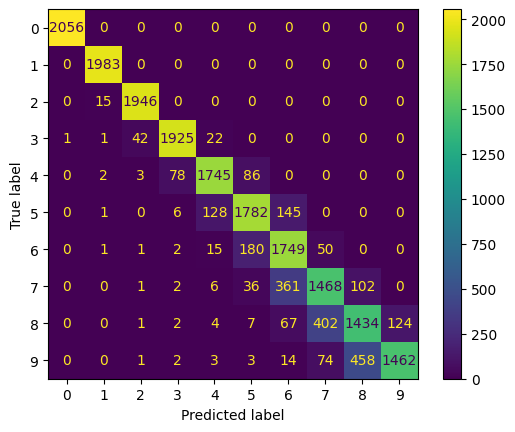

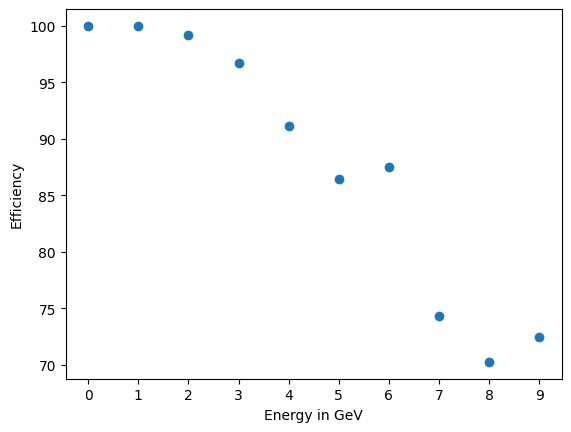

In [ ]:
conf_matrix = confusion_matrix(y_true,y_pred )
print('Confusion Matrix:\n', conf_matrix)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(conf_matrix)  #, logits,y_true, cmap=plt.cm.Blues)
matrix.plot()


plt.show()
# import numpy as np
np.save("confusion_matrix.npy", conf_matrix)
cm = np.load("confusion_matrix.npy")
# print(cm)
recall = (np.diag(cm) / cm.sum(axis=1))*100

# Plot the recall for each class
plt.scatter(range(10), recall)
plt.xticks(range(10))
# plt.ylim([0, 1])
plt.xlabel('Energy in GeV')
plt.ylabel('Efficiency')
plt.show()

In [ ]:
import csv
data = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        data.append([y_true[i], y_pred[i], graphIDs[i]])
    np.save('graphIDs.npy', graphIDs)
with open('mismatched_predictions_1.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['True Label', 'Predicted Label', 'graphID'])
    writer.writerows(data)

In [ ]:
graphID = 1000000
label = int(int(graphID) / 10000)/10.0
print(label)

10.0
